In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data=pd.read_csv("municipality_bus_utilization.csv", index_col=0, parse_dates=True)

In [4]:
data

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,9,454,1332
2017-06-04 07:59:42,8,556,2947
2017-06-04 07:59:42,4,1090,3893
2017-06-04 07:59:42,0,204,2813
2017-06-04 07:59:42,7,718,2019
...,...,...,...
2017-08-19 16:30:35,2,548,697
2017-08-19 16:30:35,8,1193,2947
2017-08-19 16:30:35,7,1354,2019


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13070 entries, 2017-06-04 07:59:42 to 2017-08-19 16:30:35
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   municipality_id  13070 non-null  int64
 1   usage            13070 non-null  int64
 2   total_capacity   13070 non-null  int64
dtypes: int64(3)
memory usage: 408.4 KB


In [6]:
data.isnull().sum()

municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [7]:
data=data.dropna()

In [8]:
df=data.copy()

In [10]:
df.loc[df.municipality_id==0]

,municipality_id,usage,total_capacity
timestamp,,,
2017-06-04 07:59:42,0,204,2813
2017-06-04 08:25:42,0,247,2813
2017-06-04 08:59:42,0,332,2813
2017-06-04 09:32:46,0,429,2813
2017-06-04 09:59:48,0,485,2813
...,...,...,...
2017-08-19 14:30:33,0,1285,2813
2017-08-19 15:03:34,0,1283,2813
2017-08-19 15:29:33,0,1286,2813


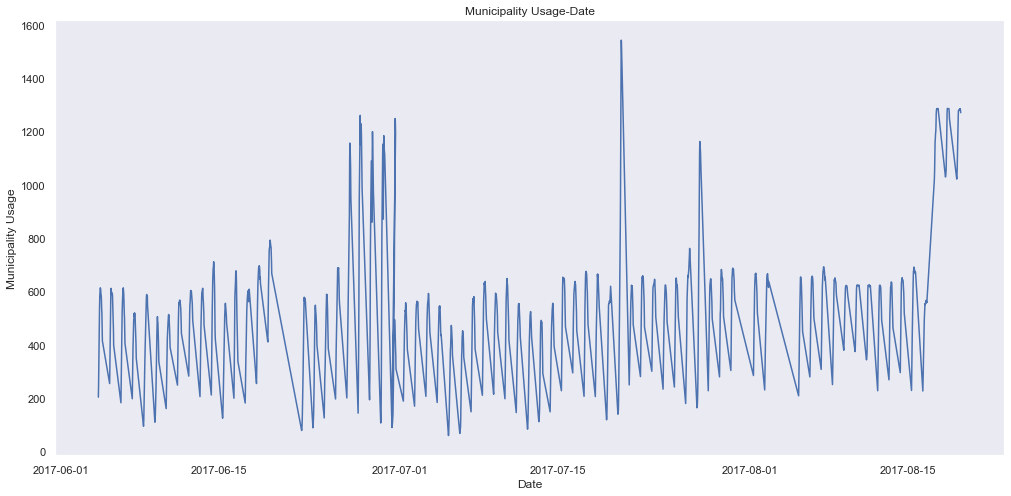

In [11]:
plt.figure(figsize=(17, 8))
plt.plot(df.loc[df.municipality_id==0].usage)
plt.title('Municipality Usage-Date')
plt.ylabel('Municipality Usage')
plt.xlabel('Date')
plt.grid(False)
plt.show()

#### Moving Average

In [74]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    dff=pd.DataFrame(rolling_mean)
    print(dff.tail(10))

In [73]:
df.loc[df.municipality_id==0].sort_index().tail(10)

,municipality_id,usage,total_capacity
timestamp,,,
2017-08-19 12:03:32,0,1279,2813
2017-08-19 12:30:32,0,1281,2813
2017-08-19 13:03:30,0,1281,2813
2017-08-19 13:30:35,0,1283,2813
2017-08-19 14:03:31,0,1283,2813
2017-08-19 14:30:33,0,1285,2813
2017-08-19 15:03:34,0,1283,2813
2017-08-19 15:29:33,0,1286,2813
2017-08-19 16:03:35,0,1276,2813


                           usage
timestamp                       
2017-08-19 12:03:32  1189.142857
2017-08-19 12:30:32  1219.571429
2017-08-19 13:03:30  1243.571429
2017-08-19 13:30:35  1262.714286
2017-08-19 14:03:31  1274.857143
2017-08-19 14:30:33  1281.428571
2017-08-19 15:03:34  1282.142857
2017-08-19 15:29:33  1283.142857
2017-08-19 16:03:35  1282.428571
2017-08-19 16:30:35  1281.000000


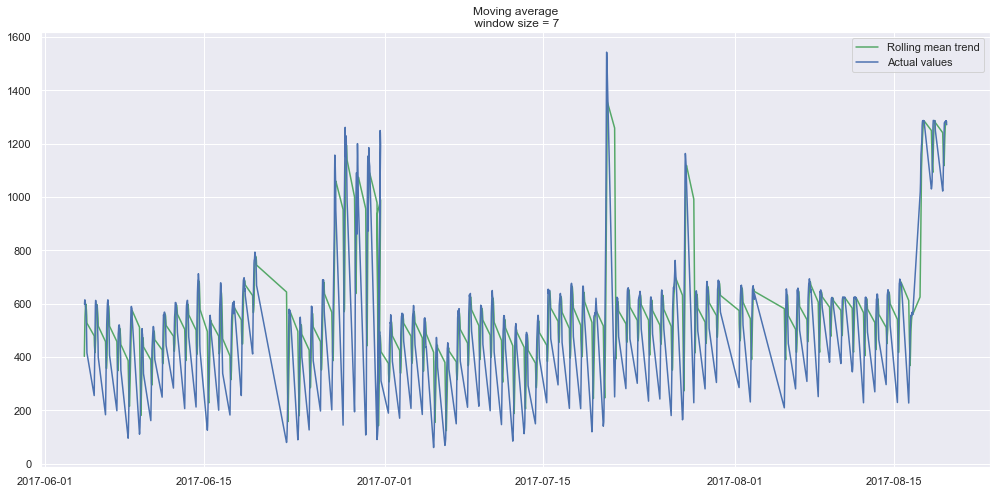

In [75]:
# Window=7 (by week)
plot_moving_average(df.loc[df.municipality_id==0].usage, 7)

#### Exponential Smoothing

No handles with labels found to put in legend.


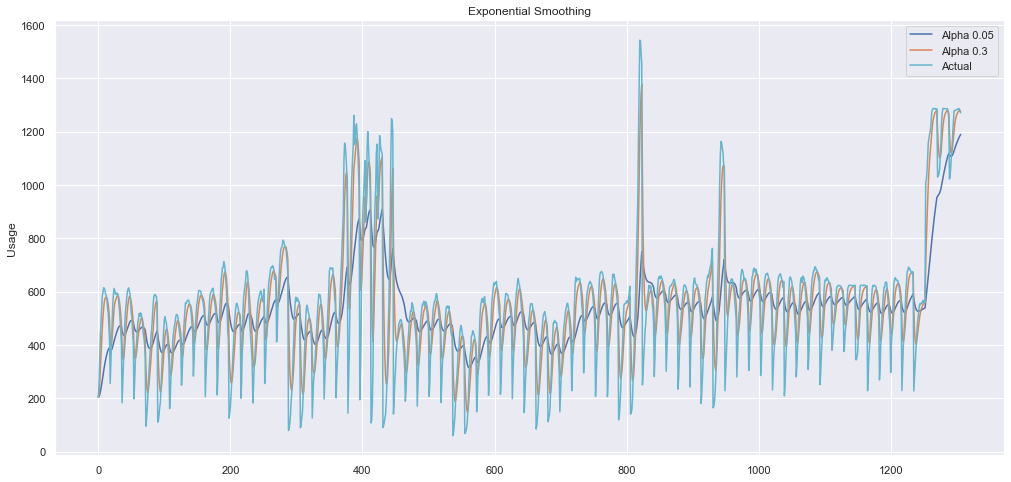

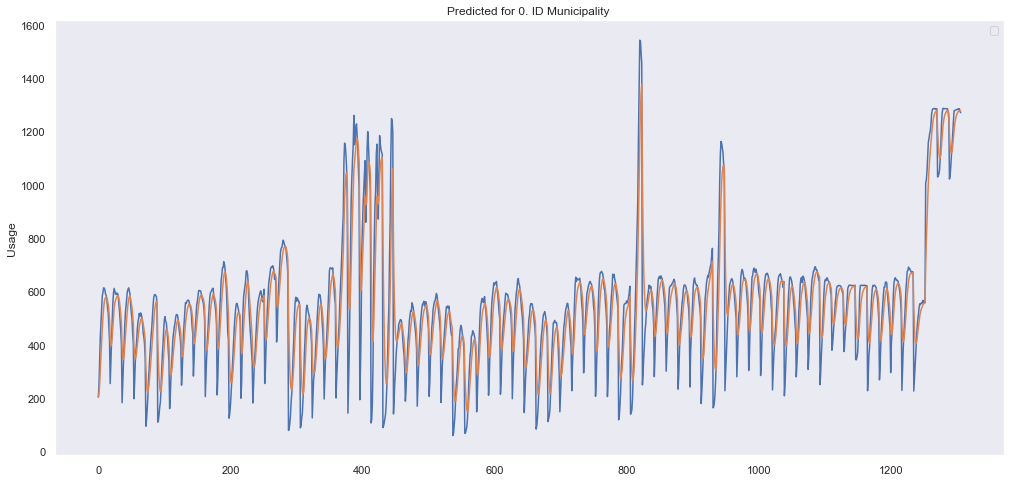

In [66]:
def exponential_smoothing(series, alpha):

    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.ylabel('Usage')
    plt.grid(True);
    dff=pd.DataFrame(exponential_smoothing(series, alpha))
#     print(dff.head(20))
    
    comparison = pd.DataFrame({'actual': series.values.tolist(),
                              'predicted': dff[0].tolist()}, 
                              )

#     print(comparison.head(10))
    #Plot predicted vs actual usage

    plt.figure(figsize=(17, 8))
    plt.plot(comparison.actual)
    plt.plot(comparison.predicted)
    plt.title('Predicted for 0. ID Municipality ')
    plt.ylabel('Usage')
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()
#     print(series.values.tolist())
#     print(dff[0].tolist())
    
plot_exponential_smoothing(df.loc[df.municipality_id==0].usage, [0.05, 0.3])

#### Actual-Predicted with Keras

In [78]:
df_train_labels=df_train.pop("usage")
df_test_labels=df_test.pop("usage")

df_train.pop("week_day_name")
df_test.pop("week_day_name")

df_train.pop("timestamp")
df_test.pop("timestamp")

10390   2017-08-05 08:02:03
10391   2017-08-05 08:02:03
10392   2017-08-05 08:02:03
10393   2017-08-05 08:02:03
10394   2017-08-05 08:02:03
                ...        
12885   2017-08-18 16:30:25
12886   2017-08-18 16:30:25
12887   2017-08-18 16:30:25
12888   2017-08-18 16:30:25
12889   2017-08-18 16:30:25
Name: timestamp, Length: 2500, dtype: datetime64[ns]

In [79]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse', 'mape'])
    return model

model = build_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
EPOCHS = 1000

tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = model.fit(
  df_train, df_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tqdm_callback])

Training:   0%|                                                                              0/1000 ETA: ?s,  …

Epoch 1/1000


0/265                                                                                                        E…

Epoch 2/1000


0/265                                                                                                        E…

Epoch 3/1000


0/265                                                                                                        E…

Epoch 4/1000


0/265                                                                                                        E…

Epoch 5/1000


0/265                                                                                                        E…

Epoch 6/1000


0/265                                                                                                        E…

Epoch 7/1000


0/265                                                                                                        E…

Epoch 8/1000


0/265                                                                                                        E…

Epoch 9/1000


0/265                                                                                                        E…

Epoch 10/1000


0/265                                                                                                        E…

Epoch 11/1000


0/265                                                                                                        E…

Epoch 12/1000


0/265                                                                                                        E…

Epoch 13/1000


0/265                                                                                                        E…

Epoch 14/1000


0/265                                                                                                        E…

Epoch 15/1000


0/265                                                                                                        E…

Epoch 16/1000


0/265                                                                                                        E…

Epoch 17/1000


0/265                                                                                                        E…

Epoch 18/1000


0/265                                                                                                        E…

Epoch 19/1000


0/265                                                                                                        E…

Epoch 20/1000


0/265                                                                                                        E…

Epoch 21/1000


0/265                                                                                                        E…

Epoch 22/1000


0/265                                                                                                        E…

Epoch 23/1000


0/265                                                                                                        E…

Epoch 24/1000


0/265                                                                                                        E…

Epoch 25/1000


0/265                                                                                                        E…

Epoch 26/1000


0/265                                                                                                        E…

Epoch 27/1000


0/265                                                                                                        E…

Epoch 28/1000


0/265                                                                                                        E…

Epoch 29/1000


0/265                                                                                                        E…

Epoch 30/1000


0/265                                                                                                        E…

Epoch 31/1000


0/265                                                                                                        E…

Epoch 32/1000


0/265                                                                                                        E…

Epoch 33/1000


0/265                                                                                                        E…

Epoch 34/1000


0/265                                                                                                        E…

Epoch 35/1000


0/265                                                                                                        E…

Epoch 36/1000


0/265                                                                                                        E…

Epoch 37/1000


0/265                                                                                                        E…

Epoch 38/1000


0/265                                                                                                        E…

Epoch 39/1000


0/265                                                                                                        E…

Epoch 40/1000


0/265                                                                                                        E…

Epoch 41/1000


0/265                                                                                                        E…

Epoch 42/1000


0/265                                                                                                        E…

Epoch 43/1000


0/265                                                                                                        E…

Epoch 44/1000


0/265                                                                                                        E…

Epoch 45/1000


0/265                                                                                                        E…

Epoch 46/1000


0/265                                                                                                        E…

Epoch 47/1000


0/265                                                                                                        E…

Epoch 48/1000


0/265                                                                                                        E…

Epoch 49/1000


0/265                                                                                                        E…

Epoch 50/1000


0/265                                                                                                        E…

Epoch 51/1000


0/265                                                                                                        E…

Epoch 52/1000


0/265                                                                                                        E…

Epoch 53/1000


0/265                                                                                                        E…

Epoch 54/1000


0/265                                                                                                        E…

Epoch 55/1000


0/265                                                                                                        E…

Epoch 56/1000


0/265                                                                                                        E…

Epoch 57/1000


0/265                                                                                                        E…

Epoch 58/1000


0/265                                                                                                        E…

Epoch 59/1000


0/265                                                                                                        E…

Epoch 60/1000


0/265                                                                                                        E…

Epoch 61/1000


0/265                                                                                                        E…

Epoch 62/1000


0/265                                                                                                        E…

Epoch 63/1000


0/265                                                                                                        E…

Epoch 64/1000


0/265                                                                                                        E…

Epoch 65/1000


0/265                                                                                                        E…

Epoch 66/1000


0/265                                                                                                        E…

Epoch 67/1000


0/265                                                                                                        E…

Epoch 68/1000


0/265                                                                                                        E…

Epoch 69/1000


0/265                                                                                                        E…

Epoch 70/1000


0/265                                                                                                        E…

Epoch 71/1000


0/265                                                                                                        E…

Epoch 72/1000


0/265                                                                                                        E…

Epoch 73/1000


0/265                                                                                                        E…

Epoch 74/1000


0/265                                                                                                        E…

Epoch 75/1000


0/265                                                                                                        E…

Epoch 76/1000


0/265                                                                                                        E…

Epoch 77/1000


0/265                                                                                                        E…

Epoch 78/1000


0/265                                                                                                        E…

Epoch 79/1000


0/265                                                                                                        E…

Epoch 80/1000


0/265                                                                                                        E…

Epoch 81/1000


0/265                                                                                                        E…

Epoch 82/1000


0/265                                                                                                        E…

Epoch 83/1000


0/265                                                                                                        E…

Epoch 84/1000


0/265                                                                                                        E…

Epoch 85/1000


0/265                                                                                                        E…

Epoch 86/1000


0/265                                                                                                        E…

Epoch 87/1000


0/265                                                                                                        E…

Epoch 88/1000


0/265                                                                                                        E…

Epoch 89/1000


0/265                                                                                                        E…

Epoch 90/1000


0/265                                                                                                        E…

Epoch 91/1000


0/265                                                                                                        E…

Epoch 92/1000


0/265                                                                                                        E…

Epoch 93/1000


0/265                                                                                                        E…

Epoch 94/1000


0/265                                                                                                        E…

Epoch 95/1000


0/265                                                                                                        E…

Epoch 96/1000


0/265                                                                                                        E…

Epoch 97/1000


0/265                                                                                                        E…

Epoch 98/1000


0/265                                                                                                        E…

Epoch 99/1000


0/265                                                                                                        E…

Epoch 100/1000


0/265                                                                                                        E…

Epoch 101/1000


0/265                                                                                                        E…

Epoch 102/1000


0/265                                                                                                        E…

Epoch 103/1000


0/265                                                                                                        E…

Epoch 104/1000


0/265                                                                                                        E…

Epoch 105/1000


0/265                                                                                                        E…

Epoch 106/1000


0/265                                                                                                        E…

Epoch 107/1000


0/265                                                                                                        E…

Epoch 108/1000


0/265                                                                                                        E…

Epoch 109/1000


0/265                                                                                                        E…

Epoch 110/1000


0/265                                                                                                        E…

Epoch 111/1000


0/265                                                                                                        E…

Epoch 112/1000


0/265                                                                                                        E…

Epoch 113/1000


0/265                                                                                                        E…

Epoch 114/1000


0/265                                                                                                        E…

Epoch 115/1000


0/265                                                                                                        E…

Epoch 116/1000


0/265                                                                                                        E…

Epoch 117/1000


0/265                                                                                                        E…

Epoch 118/1000


0/265                                                                                                        E…

Epoch 119/1000


0/265                                                                                                        E…

Epoch 120/1000


0/265                                                                                                        E…

Epoch 121/1000


0/265                                                                                                        E…

Epoch 122/1000


0/265                                                                                                        E…

Epoch 123/1000


0/265                                                                                                        E…

Epoch 124/1000


0/265                                                                                                        E…

Epoch 125/1000


0/265                                                                                                        E…

Epoch 126/1000


0/265                                                                                                        E…

Epoch 127/1000


0/265                                                                                                        E…

Epoch 128/1000


0/265                                                                                                        E…

Epoch 129/1000


0/265                                                                                                        E…

Epoch 130/1000


0/265                                                                                                        E…

Epoch 131/1000


0/265                                                                                                        E…

Epoch 132/1000


0/265                                                                                                        E…

Epoch 133/1000


0/265                                                                                                        E…

Epoch 134/1000


0/265                                                                                                        E…

Epoch 135/1000


0/265                                                                                                        E…

Epoch 136/1000


0/265                                                                                                        E…

Epoch 137/1000


0/265                                                                                                        E…

Epoch 138/1000


0/265                                                                                                        E…

Epoch 139/1000


0/265                                                                                                        E…

Epoch 140/1000


0/265                                                                                                        E…

Epoch 141/1000


0/265                                                                                                        E…

Epoch 142/1000


0/265                                                                                                        E…

Epoch 143/1000


0/265                                                                                                        E…

Epoch 144/1000


0/265                                                                                                        E…

Epoch 145/1000


0/265                                                                                                        E…

Epoch 146/1000


0/265                                                                                                        E…

Epoch 147/1000


0/265                                                                                                        E…

Epoch 148/1000


0/265                                                                                                        E…

Epoch 149/1000


0/265                                                                                                        E…

Epoch 150/1000


0/265                                                                                                        E…

Epoch 151/1000


0/265                                                                                                        E…

Epoch 152/1000


0/265                                                                                                        E…

Epoch 153/1000


0/265                                                                                                        E…

Epoch 154/1000


0/265                                                                                                        E…

Epoch 155/1000


0/265                                                                                                        E…

Epoch 156/1000


0/265                                                                                                        E…

Epoch 157/1000


0/265                                                                                                        E…

Epoch 158/1000


0/265                                                                                                        E…

Epoch 159/1000


0/265                                                                                                        E…

Epoch 160/1000


0/265                                                                                                        E…

Epoch 161/1000


0/265                                                                                                        E…

Epoch 162/1000


0/265                                                                                                        E…

Epoch 163/1000


0/265                                                                                                        E…

Epoch 164/1000


0/265                                                                                                        E…

Epoch 165/1000


0/265                                                                                                        E…

Epoch 166/1000


0/265                                                                                                        E…

Epoch 167/1000


0/265                                                                                                        E…

Epoch 168/1000


0/265                                                                                                        E…

Epoch 169/1000


0/265                                                                                                        E…

Epoch 170/1000


0/265                                                                                                        E…

Epoch 171/1000


0/265                                                                                                        E…

Epoch 172/1000


0/265                                                                                                        E…

Epoch 173/1000


0/265                                                                                                        E…

Epoch 174/1000


0/265                                                                                                        E…

Epoch 175/1000


0/265                                                                                                        E…

Epoch 176/1000


0/265                                                                                                        E…

Epoch 177/1000


0/265                                                                                                        E…

Epoch 178/1000


0/265                                                                                                        E…

Epoch 179/1000


0/265                                                                                                        E…

Epoch 180/1000


0/265                                                                                                        E…

Epoch 181/1000


0/265                                                                                                        E…

Epoch 182/1000


0/265                                                                                                        E…

Epoch 183/1000


0/265                                                                                                        E…

Epoch 184/1000


0/265                                                                                                        E…

Epoch 185/1000


0/265                                                                                                        E…

Epoch 186/1000


0/265                                                                                                        E…

Epoch 187/1000


0/265                                                                                                        E…

Epoch 188/1000


0/265                                                                                                        E…

Epoch 189/1000


0/265                                                                                                        E…

Epoch 190/1000


0/265                                                                                                        E…

Epoch 191/1000


0/265                                                                                                        E…

Epoch 192/1000


0/265                                                                                                        E…

Epoch 193/1000


0/265                                                                                                        E…

Epoch 194/1000


0/265                                                                                                        E…

Epoch 195/1000


0/265                                                                                                        E…

Epoch 196/1000


0/265                                                                                                        E…

Epoch 197/1000


0/265                                                                                                        E…

Epoch 198/1000


0/265                                                                                                        E…

Epoch 199/1000


0/265                                                                                                        E…

Epoch 200/1000


0/265                                                                                                        E…

Epoch 201/1000


0/265                                                                                                        E…

Epoch 202/1000


0/265                                                                                                        E…

Epoch 203/1000


0/265                                                                                                        E…

Epoch 204/1000


0/265                                                                                                        E…

Epoch 205/1000


0/265                                                                                                        E…

Epoch 206/1000


0/265                                                                                                        E…

Epoch 207/1000


0/265                                                                                                        E…

Epoch 208/1000


0/265                                                                                                        E…

Epoch 209/1000


0/265                                                                                                        E…

Epoch 210/1000


0/265                                                                                                        E…

Epoch 211/1000


0/265                                                                                                        E…

Epoch 212/1000


0/265                                                                                                        E…

Epoch 213/1000


0/265                                                                                                        E…

Epoch 214/1000


0/265                                                                                                        E…

Epoch 215/1000


0/265                                                                                                        E…

Epoch 216/1000


0/265                                                                                                        E…

Epoch 217/1000


0/265                                                                                                        E…

Epoch 218/1000


0/265                                                                                                        E…

Epoch 219/1000


0/265                                                                                                        E…

Epoch 220/1000


0/265                                                                                                        E…

Epoch 221/1000


0/265                                                                                                        E…

Epoch 222/1000


0/265                                                                                                        E…

Epoch 223/1000


0/265                                                                                                        E…

Epoch 224/1000


0/265                                                                                                        E…

Epoch 225/1000


0/265                                                                                                        E…

Epoch 226/1000


0/265                                                                                                        E…

Epoch 227/1000


0/265                                                                                                        E…

Epoch 228/1000


0/265                                                                                                        E…

Epoch 229/1000


0/265                                                                                                        E…

Epoch 230/1000


0/265                                                                                                        E…

Epoch 231/1000


0/265                                                                                                        E…

Epoch 232/1000


0/265                                                                                                        E…

Epoch 233/1000


0/265                                                                                                        E…

Epoch 234/1000


0/265                                                                                                        E…

Epoch 235/1000


0/265                                                                                                        E…

Epoch 236/1000


0/265                                                                                                        E…

Epoch 237/1000


0/265                                                                                                        E…

Epoch 238/1000


0/265                                                                                                        E…

Epoch 239/1000


0/265                                                                                                        E…

Epoch 240/1000


0/265                                                                                                        E…

Epoch 241/1000


0/265                                                                                                        E…

Epoch 242/1000


0/265                                                                                                        E…

Epoch 243/1000


0/265                                                                                                        E…

Epoch 244/1000


0/265                                                                                                        E…

Epoch 245/1000


0/265                                                                                                        E…

Epoch 246/1000


0/265                                                                                                        E…

Epoch 247/1000


0/265                                                                                                        E…

Epoch 248/1000


0/265                                                                                                        E…

Epoch 249/1000


0/265                                                                                                        E…

Epoch 250/1000


0/265                                                                                                        E…

Epoch 251/1000


0/265                                                                                                        E…

Epoch 252/1000


0/265                                                                                                        E…

Epoch 253/1000


0/265                                                                                                        E…

Epoch 254/1000


0/265                                                                                                        E…

Epoch 255/1000


0/265                                                                                                        E…

Epoch 256/1000


0/265                                                                                                        E…

Epoch 257/1000


0/265                                                                                                        E…

Epoch 258/1000


0/265                                                                                                        E…

Epoch 259/1000


0/265                                                                                                        E…

Epoch 260/1000


0/265                                                                                                        E…

Epoch 261/1000


0/265                                                                                                        E…

Epoch 262/1000


0/265                                                                                                        E…

Epoch 263/1000


0/265                                                                                                        E…

Epoch 264/1000


0/265                                                                                                        E…

Epoch 265/1000


0/265                                                                                                        E…

Epoch 266/1000


0/265                                                                                                        E…

Epoch 267/1000


0/265                                                                                                        E…

Epoch 268/1000


0/265                                                                                                        E…

Epoch 269/1000


0/265                                                                                                        E…

Epoch 270/1000


0/265                                                                                                        E…

Epoch 271/1000


0/265                                                                                                        E…

Epoch 272/1000


0/265                                                                                                        E…

Epoch 273/1000


0/265                                                                                                        E…

Epoch 274/1000


0/265                                                                                                        E…

Epoch 275/1000


0/265                                                                                                        E…

Epoch 276/1000


0/265                                                                                                        E…

Epoch 277/1000


0/265                                                                                                        E…

Epoch 278/1000


0/265                                                                                                        E…

Epoch 279/1000


0/265                                                                                                        E…

Epoch 280/1000


0/265                                                                                                        E…

Epoch 281/1000


0/265                                                                                                        E…

Epoch 282/1000


0/265                                                                                                        E…

Epoch 283/1000


0/265                                                                                                        E…

Epoch 284/1000


0/265                                                                                                        E…

Epoch 285/1000


0/265                                                                                                        E…

Epoch 286/1000


0/265                                                                                                        E…

Epoch 287/1000


0/265                                                                                                        E…

Epoch 288/1000


0/265                                                                                                        E…

Epoch 289/1000


0/265                                                                                                        E…

Epoch 290/1000


0/265                                                                                                        E…

Epoch 291/1000


0/265                                                                                                        E…

Epoch 292/1000


0/265                                                                                                        E…

Epoch 293/1000


0/265                                                                                                        E…

Epoch 294/1000


0/265                                                                                                        E…

Epoch 295/1000


0/265                                                                                                        E…

Epoch 296/1000


0/265                                                                                                        E…

Epoch 297/1000


0/265                                                                                                        E…

Epoch 298/1000


0/265                                                                                                        E…

Epoch 299/1000


0/265                                                                                                        E…

Epoch 300/1000


0/265                                                                                                        E…

Epoch 301/1000


0/265                                                                                                        E…

Epoch 302/1000


0/265                                                                                                        E…

Epoch 303/1000


0/265                                                                                                        E…

Epoch 304/1000


0/265                                                                                                        E…

Epoch 305/1000


0/265                                                                                                        E…

Epoch 306/1000


0/265                                                                                                        E…

Epoch 307/1000


0/265                                                                                                        E…

Epoch 308/1000


0/265                                                                                                        E…

Epoch 309/1000


0/265                                                                                                        E…

Epoch 310/1000


0/265                                                                                                        E…

Epoch 311/1000


0/265                                                                                                        E…

Epoch 312/1000


0/265                                                                                                        E…

Epoch 313/1000


0/265                                                                                                        E…

Epoch 314/1000


0/265                                                                                                        E…

Epoch 315/1000


0/265                                                                                                        E…

Epoch 316/1000


0/265                                                                                                        E…

Epoch 317/1000


0/265                                                                                                        E…

Epoch 318/1000


0/265                                                                                                        E…

Epoch 319/1000


0/265                                                                                                        E…

Epoch 320/1000


0/265                                                                                                        E…

Epoch 321/1000


0/265                                                                                                        E…

Epoch 322/1000


0/265                                                                                                        E…

Epoch 323/1000


0/265                                                                                                        E…

Epoch 324/1000


0/265                                                                                                        E…

Epoch 325/1000


0/265                                                                                                        E…

Epoch 326/1000


0/265                                                                                                        E…

Epoch 327/1000


0/265                                                                                                        E…

Epoch 328/1000


0/265                                                                                                        E…

Epoch 329/1000


0/265                                                                                                        E…

Epoch 330/1000


0/265                                                                                                        E…

Epoch 331/1000


0/265                                                                                                        E…

Epoch 332/1000


0/265                                                                                                        E…

Epoch 333/1000


0/265                                                                                                        E…

Epoch 334/1000


0/265                                                                                                        E…

Epoch 335/1000


0/265                                                                                                        E…

Epoch 336/1000


0/265                                                                                                        E…

Epoch 337/1000


0/265                                                                                                        E…

Epoch 338/1000


0/265                                                                                                        E…

Epoch 339/1000


0/265                                                                                                        E…

Epoch 340/1000


0/265                                                                                                        E…

Epoch 341/1000


0/265                                                                                                        E…

Epoch 342/1000


0/265                                                                                                        E…

Epoch 343/1000


0/265                                                                                                        E…

Epoch 344/1000


0/265                                                                                                        E…

Epoch 345/1000


0/265                                                                                                        E…

Epoch 346/1000


0/265                                                                                                        E…

Epoch 347/1000


0/265                                                                                                        E…

Epoch 348/1000


0/265                                                                                                        E…

Epoch 349/1000


0/265                                                                                                        E…

Epoch 350/1000


0/265                                                                                                        E…

Epoch 351/1000


0/265                                                                                                        E…

Epoch 352/1000


0/265                                                                                                        E…

Epoch 353/1000


0/265                                                                                                        E…

Epoch 354/1000


0/265                                                                                                        E…

Epoch 355/1000


0/265                                                                                                        E…

Epoch 356/1000


0/265                                                                                                        E…

Epoch 357/1000


0/265                                                                                                        E…

Epoch 358/1000


0/265                                                                                                        E…

Epoch 359/1000


0/265                                                                                                        E…

Epoch 360/1000


0/265                                                                                                        E…

Epoch 361/1000


0/265                                                                                                        E…

Epoch 362/1000


0/265                                                                                                        E…

Epoch 363/1000


0/265                                                                                                        E…

Epoch 364/1000


0/265                                                                                                        E…

Epoch 365/1000


0/265                                                                                                        E…

Epoch 366/1000


0/265                                                                                                        E…

Epoch 367/1000


0/265                                                                                                        E…

Epoch 368/1000


0/265                                                                                                        E…

Epoch 369/1000


0/265                                                                                                        E…

Epoch 370/1000


0/265                                                                                                        E…

Epoch 371/1000


0/265                                                                                                        E…

Epoch 372/1000


0/265                                                                                                        E…

Epoch 373/1000


0/265                                                                                                        E…

Epoch 374/1000


0/265                                                                                                        E…

Epoch 375/1000


0/265                                                                                                        E…

Epoch 376/1000


0/265                                                                                                        E…

Epoch 377/1000


0/265                                                                                                        E…

Epoch 378/1000


0/265                                                                                                        E…

Epoch 379/1000


0/265                                                                                                        E…

Epoch 380/1000


0/265                                                                                                        E…

Epoch 381/1000


0/265                                                                                                        E…

Epoch 382/1000


0/265                                                                                                        E…

Epoch 383/1000


0/265                                                                                                        E…

Epoch 384/1000


0/265                                                                                                        E…

Epoch 385/1000


0/265                                                                                                        E…

Epoch 386/1000


0/265                                                                                                        E…

Epoch 387/1000


0/265                                                                                                        E…

Epoch 388/1000


0/265                                                                                                        E…

Epoch 389/1000


0/265                                                                                                        E…

Epoch 390/1000


0/265                                                                                                        E…

Epoch 391/1000


0/265                                                                                                        E…

Epoch 392/1000


0/265                                                                                                        E…

Epoch 393/1000


0/265                                                                                                        E…

Epoch 394/1000


0/265                                                                                                        E…

Epoch 395/1000


0/265                                                                                                        E…

Epoch 396/1000


0/265                                                                                                        E…

Epoch 397/1000


0/265                                                                                                        E…

Epoch 398/1000


0/265                                                                                                        E…

Epoch 399/1000


0/265                                                                                                        E…

Epoch 400/1000


0/265                                                                                                        E…

Epoch 401/1000


0/265                                                                                                        E…

Epoch 402/1000


0/265                                                                                                        E…

Epoch 403/1000


0/265                                                                                                        E…

Epoch 404/1000


0/265                                                                                                        E…

Epoch 405/1000


0/265                                                                                                        E…

Epoch 406/1000


0/265                                                                                                        E…

Epoch 407/1000


0/265                                                                                                        E…

Epoch 408/1000


0/265                                                                                                        E…

Epoch 409/1000


0/265                                                                                                        E…

Epoch 410/1000


0/265                                                                                                        E…

Epoch 411/1000


0/265                                                                                                        E…

Epoch 412/1000


0/265                                                                                                        E…

Epoch 413/1000


0/265                                                                                                        E…

Epoch 414/1000


0/265                                                                                                        E…

Epoch 415/1000


0/265                                                                                                        E…

Epoch 416/1000


0/265                                                                                                        E…

Epoch 417/1000


0/265                                                                                                        E…

Epoch 418/1000


0/265                                                                                                        E…

Epoch 419/1000


0/265                                                                                                        E…

Epoch 420/1000


0/265                                                                                                        E…

Epoch 421/1000


0/265                                                                                                        E…

Epoch 422/1000


0/265                                                                                                        E…

Epoch 423/1000


0/265                                                                                                        E…

Epoch 424/1000


0/265                                                                                                        E…

Epoch 425/1000


0/265                                                                                                        E…

Epoch 426/1000


0/265                                                                                                        E…

Epoch 427/1000


0/265                                                                                                        E…

Epoch 428/1000


0/265                                                                                                        E…

Epoch 429/1000


0/265                                                                                                        E…

Epoch 430/1000


0/265                                                                                                        E…

Epoch 431/1000


0/265                                                                                                        E…

Epoch 432/1000


0/265                                                                                                        E…

Epoch 433/1000


0/265                                                                                                        E…

Epoch 434/1000


0/265                                                                                                        E…

Epoch 435/1000


0/265                                                                                                        E…

Epoch 436/1000


0/265                                                                                                        E…

Epoch 437/1000


0/265                                                                                                        E…

Epoch 438/1000


0/265                                                                                                        E…

Epoch 439/1000


0/265                                                                                                        E…

Epoch 440/1000


0/265                                                                                                        E…

Epoch 441/1000


0/265                                                                                                        E…

Epoch 442/1000


0/265                                                                                                        E…

Epoch 443/1000


0/265                                                                                                        E…

Epoch 444/1000


0/265                                                                                                        E…

Epoch 445/1000


0/265                                                                                                        E…

Epoch 446/1000


0/265                                                                                                        E…

Epoch 447/1000


0/265                                                                                                        E…

Epoch 448/1000


0/265                                                                                                        E…

Epoch 449/1000


0/265                                                                                                        E…

Epoch 450/1000


0/265                                                                                                        E…

Epoch 451/1000


0/265                                                                                                        E…

Epoch 452/1000


0/265                                                                                                        E…

Epoch 453/1000


0/265                                                                                                        E…

Epoch 454/1000


0/265                                                                                                        E…

Epoch 455/1000


0/265                                                                                                        E…

Epoch 456/1000


0/265                                                                                                        E…

Epoch 457/1000


0/265                                                                                                        E…

Epoch 458/1000


0/265                                                                                                        E…

Epoch 459/1000


0/265                                                                                                        E…

Epoch 460/1000


0/265                                                                                                        E…

Epoch 461/1000


0/265                                                                                                        E…

Epoch 462/1000


0/265                                                                                                        E…

Epoch 463/1000


0/265                                                                                                        E…

Epoch 464/1000


0/265                                                                                                        E…

Epoch 465/1000


0/265                                                                                                        E…

Epoch 466/1000


0/265                                                                                                        E…

Epoch 467/1000


0/265                                                                                                        E…

Epoch 468/1000


0/265                                                                                                        E…

Epoch 469/1000


0/265                                                                                                        E…

Epoch 470/1000


0/265                                                                                                        E…

Epoch 471/1000


0/265                                                                                                        E…

Epoch 472/1000


0/265                                                                                                        E…

Epoch 473/1000


0/265                                                                                                        E…

Epoch 474/1000


0/265                                                                                                        E…

Epoch 475/1000


0/265                                                                                                        E…

Epoch 476/1000


0/265                                                                                                        E…

Epoch 477/1000


0/265                                                                                                        E…

Epoch 478/1000


0/265                                                                                                        E…

Epoch 479/1000


0/265                                                                                                        E…

Epoch 480/1000


0/265                                                                                                        E…

Epoch 481/1000


0/265                                                                                                        E…

Epoch 482/1000


0/265                                                                                                        E…

Epoch 483/1000


0/265                                                                                                        E…

Epoch 484/1000


0/265                                                                                                        E…

Epoch 485/1000


0/265                                                                                                        E…

Epoch 486/1000


0/265                                                                                                        E…

Epoch 487/1000


0/265                                                                                                        E…

Epoch 488/1000


0/265                                                                                                        E…

Epoch 489/1000


0/265                                                                                                        E…

Epoch 490/1000


0/265                                                                                                        E…

Epoch 491/1000


0/265                                                                                                        E…

Epoch 492/1000


0/265                                                                                                        E…

Epoch 493/1000


0/265                                                                                                        E…

Epoch 494/1000


0/265                                                                                                        E…

Epoch 495/1000


0/265                                                                                                        E…

Epoch 496/1000


0/265                                                                                                        E…

Epoch 497/1000


0/265                                                                                                        E…

Epoch 498/1000


0/265                                                                                                        E…

Epoch 499/1000


0/265                                                                                                        E…

Epoch 500/1000


0/265                                                                                                        E…

Epoch 501/1000


0/265                                                                                                        E…

Epoch 502/1000


0/265                                                                                                        E…

Epoch 503/1000


0/265                                                                                                        E…

Epoch 504/1000


0/265                                                                                                        E…

Epoch 505/1000


0/265                                                                                                        E…

Epoch 506/1000


0/265                                                                                                        E…

Epoch 507/1000


0/265                                                                                                        E…

Epoch 508/1000


0/265                                                                                                        E…

Epoch 509/1000


0/265                                                                                                        E…

Epoch 510/1000


0/265                                                                                                        E…

Epoch 511/1000


0/265                                                                                                        E…

Epoch 512/1000


0/265                                                                                                        E…

Epoch 513/1000


0/265                                                                                                        E…

Epoch 514/1000


0/265                                                                                                        E…

Epoch 515/1000


0/265                                                                                                        E…

Epoch 516/1000


0/265                                                                                                        E…

Epoch 517/1000


0/265                                                                                                        E…

Epoch 518/1000


0/265                                                                                                        E…

Epoch 519/1000


0/265                                                                                                        E…

Epoch 520/1000


0/265                                                                                                        E…

Epoch 521/1000


0/265                                                                                                        E…

Epoch 522/1000


0/265                                                                                                        E…

Epoch 523/1000


0/265                                                                                                        E…

Epoch 524/1000


0/265                                                                                                        E…

Epoch 525/1000


0/265                                                                                                        E…

Epoch 526/1000


0/265                                                                                                        E…

Epoch 527/1000


0/265                                                                                                        E…

Epoch 528/1000


0/265                                                                                                        E…

Epoch 529/1000


0/265                                                                                                        E…

Epoch 530/1000


0/265                                                                                                        E…

Epoch 531/1000


0/265                                                                                                        E…

Epoch 532/1000


0/265                                                                                                        E…

Epoch 533/1000


0/265                                                                                                        E…

Epoch 534/1000


0/265                                                                                                        E…

Epoch 535/1000


0/265                                                                                                        E…

Epoch 536/1000


0/265                                                                                                        E…

Epoch 537/1000


0/265                                                                                                        E…

Epoch 538/1000


0/265                                                                                                        E…

Epoch 539/1000


0/265                                                                                                        E…

Epoch 540/1000


0/265                                                                                                        E…

Epoch 541/1000


0/265                                                                                                        E…

Epoch 542/1000


0/265                                                                                                        E…

Epoch 543/1000


0/265                                                                                                        E…

Epoch 544/1000


0/265                                                                                                        E…

Epoch 545/1000


0/265                                                                                                        E…

Epoch 546/1000


0/265                                                                                                        E…

Epoch 547/1000


0/265                                                                                                        E…

Epoch 548/1000


0/265                                                                                                        E…

Epoch 549/1000


0/265                                                                                                        E…

Epoch 550/1000


0/265                                                                                                        E…

Epoch 551/1000


0/265                                                                                                        E…

Epoch 552/1000


0/265                                                                                                        E…

Epoch 553/1000


0/265                                                                                                        E…

Epoch 554/1000


0/265                                                                                                        E…

Epoch 555/1000


0/265                                                                                                        E…

Epoch 556/1000


0/265                                                                                                        E…

Epoch 557/1000


0/265                                                                                                        E…

Epoch 558/1000


0/265                                                                                                        E…

Epoch 559/1000


0/265                                                                                                        E…

Epoch 560/1000


0/265                                                                                                        E…

Epoch 561/1000


0/265                                                                                                        E…

Epoch 562/1000


0/265                                                                                                        E…

Epoch 563/1000


0/265                                                                                                        E…

Epoch 564/1000


0/265                                                                                                        E…

Epoch 565/1000


0/265                                                                                                        E…

Epoch 566/1000


0/265                                                                                                        E…

Epoch 567/1000


0/265                                                                                                        E…

Epoch 568/1000


0/265                                                                                                        E…

Epoch 569/1000


0/265                                                                                                        E…

Epoch 570/1000


0/265                                                                                                        E…

Epoch 571/1000


0/265                                                                                                        E…

Epoch 572/1000


0/265                                                                                                        E…

Epoch 573/1000


0/265                                                                                                        E…

Epoch 574/1000


0/265                                                                                                        E…

Epoch 575/1000


0/265                                                                                                        E…

Epoch 576/1000


0/265                                                                                                        E…

Epoch 577/1000


0/265                                                                                                        E…

Epoch 578/1000


0/265                                                                                                        E…

Epoch 579/1000


0/265                                                                                                        E…

Epoch 580/1000


0/265                                                                                                        E…

Epoch 581/1000


0/265                                                                                                        E…

Epoch 582/1000


0/265                                                                                                        E…

Epoch 583/1000


0/265                                                                                                        E…

Epoch 584/1000


0/265                                                                                                        E…

Epoch 585/1000


0/265                                                                                                        E…

Epoch 586/1000


0/265                                                                                                        E…

Epoch 587/1000


0/265                                                                                                        E…

Epoch 588/1000


0/265                                                                                                        E…

Epoch 589/1000


0/265                                                                                                        E…

Epoch 590/1000


0/265                                                                                                        E…

Epoch 591/1000


0/265                                                                                                        E…

Epoch 592/1000


0/265                                                                                                        E…

Epoch 593/1000


0/265                                                                                                        E…

Epoch 594/1000


0/265                                                                                                        E…

Epoch 595/1000


0/265                                                                                                        E…

Epoch 596/1000


0/265                                                                                                        E…

Epoch 597/1000


0/265                                                                                                        E…

Epoch 598/1000


0/265                                                                                                        E…

Epoch 599/1000


0/265                                                                                                        E…

Epoch 600/1000


0/265                                                                                                        E…

Epoch 601/1000


0/265                                                                                                        E…

Epoch 602/1000


0/265                                                                                                        E…

Epoch 603/1000


0/265                                                                                                        E…

Epoch 604/1000


0/265                                                                                                        E…

Epoch 605/1000


0/265                                                                                                        E…

Epoch 606/1000


0/265                                                                                                        E…

Epoch 607/1000


0/265                                                                                                        E…

Epoch 608/1000


0/265                                                                                                        E…

Epoch 609/1000


0/265                                                                                                        E…

Epoch 610/1000


0/265                                                                                                        E…

Epoch 611/1000


0/265                                                                                                        E…

Epoch 612/1000


0/265                                                                                                        E…

Epoch 613/1000


0/265                                                                                                        E…

Epoch 614/1000


0/265                                                                                                        E…

Epoch 615/1000


0/265                                                                                                        E…

Epoch 616/1000


0/265                                                                                                        E…

Epoch 617/1000


0/265                                                                                                        E…

Epoch 618/1000


0/265                                                                                                        E…

Epoch 619/1000


0/265                                                                                                        E…

Epoch 620/1000


0/265                                                                                                        E…

Epoch 621/1000


0/265                                                                                                        E…

Epoch 622/1000


0/265                                                                                                        E…

Epoch 623/1000


0/265                                                                                                        E…

Epoch 624/1000


0/265                                                                                                        E…

Epoch 625/1000


0/265                                                                                                        E…

Epoch 626/1000


0/265                                                                                                        E…

Epoch 627/1000


0/265                                                                                                        E…

Epoch 628/1000


0/265                                                                                                        E…

Epoch 629/1000


0/265                                                                                                        E…

Epoch 630/1000


0/265                                                                                                        E…

Epoch 631/1000


0/265                                                                                                        E…

Epoch 632/1000


0/265                                                                                                        E…

Epoch 633/1000


0/265                                                                                                        E…

Epoch 634/1000


0/265                                                                                                        E…

Epoch 635/1000


0/265                                                                                                        E…

Epoch 636/1000


0/265                                                                                                        E…

Epoch 637/1000


0/265                                                                                                        E…

Epoch 638/1000


0/265                                                                                                        E…

Epoch 639/1000


0/265                                                                                                        E…

Epoch 640/1000


0/265                                                                                                        E…

Epoch 641/1000


0/265                                                                                                        E…

Epoch 642/1000


0/265                                                                                                        E…

Epoch 643/1000


0/265                                                                                                        E…

Epoch 644/1000


0/265                                                                                                        E…

Epoch 645/1000


0/265                                                                                                        E…

Epoch 646/1000


0/265                                                                                                        E…

Epoch 647/1000


0/265                                                                                                        E…

Epoch 648/1000


0/265                                                                                                        E…

Epoch 649/1000


0/265                                                                                                        E…

Epoch 650/1000


0/265                                                                                                        E…

Epoch 651/1000


0/265                                                                                                        E…

Epoch 652/1000


0/265                                                                                                        E…

Epoch 653/1000


0/265                                                                                                        E…

Epoch 654/1000


0/265                                                                                                        E…

Epoch 655/1000


0/265                                                                                                        E…

Epoch 656/1000


0/265                                                                                                        E…

Epoch 657/1000


0/265                                                                                                        E…

Epoch 658/1000


0/265                                                                                                        E…

Epoch 659/1000


0/265                                                                                                        E…

Epoch 660/1000


0/265                                                                                                        E…

Epoch 661/1000


0/265                                                                                                        E…

Epoch 662/1000


0/265                                                                                                        E…

Epoch 663/1000


0/265                                                                                                        E…

Epoch 664/1000


0/265                                                                                                        E…

Epoch 665/1000


0/265                                                                                                        E…

Epoch 666/1000


0/265                                                                                                        E…

Epoch 667/1000


0/265                                                                                                        E…

Epoch 668/1000


0/265                                                                                                        E…

Epoch 669/1000


0/265                                                                                                        E…

Epoch 670/1000


0/265                                                                                                        E…

Epoch 671/1000


0/265                                                                                                        E…

Epoch 672/1000


0/265                                                                                                        E…

Epoch 673/1000


0/265                                                                                                        E…

Epoch 674/1000


0/265                                                                                                        E…

Epoch 675/1000


0/265                                                                                                        E…

Epoch 676/1000


0/265                                                                                                        E…

Epoch 677/1000


0/265                                                                                                        E…

Epoch 678/1000


0/265                                                                                                        E…

Epoch 679/1000


0/265                                                                                                        E…

Epoch 680/1000


0/265                                                                                                        E…

Epoch 681/1000


0/265                                                                                                        E…

Epoch 682/1000


0/265                                                                                                        E…

Epoch 683/1000


0/265                                                                                                        E…

Epoch 684/1000


0/265                                                                                                        E…

Epoch 685/1000


0/265                                                                                                        E…

Epoch 686/1000


0/265                                                                                                        E…

Epoch 687/1000


0/265                                                                                                        E…

Epoch 688/1000


0/265                                                                                                        E…

Epoch 689/1000


0/265                                                                                                        E…

Epoch 690/1000


0/265                                                                                                        E…

Epoch 691/1000


0/265                                                                                                        E…

Epoch 692/1000


0/265                                                                                                        E…

Epoch 693/1000


0/265                                                                                                        E…

Epoch 694/1000


0/265                                                                                                        E…

Epoch 695/1000


0/265                                                                                                        E…

Epoch 696/1000


0/265                                                                                                        E…

Epoch 697/1000


0/265                                                                                                        E…

Epoch 698/1000


0/265                                                                                                        E…

Epoch 699/1000


0/265                                                                                                        E…

Epoch 700/1000


0/265                                                                                                        E…

Epoch 701/1000


0/265                                                                                                        E…

Epoch 702/1000


0/265                                                                                                        E…

Epoch 703/1000


0/265                                                                                                        E…

Epoch 704/1000


0/265                                                                                                        E…

Epoch 705/1000


0/265                                                                                                        E…

Epoch 706/1000


0/265                                                                                                        E…

Epoch 707/1000


0/265                                                                                                        E…

Epoch 708/1000


0/265                                                                                                        E…

Epoch 709/1000


0/265                                                                                                        E…

Epoch 710/1000


0/265                                                                                                        E…

Epoch 711/1000


0/265                                                                                                        E…

Epoch 712/1000


0/265                                                                                                        E…

Epoch 713/1000


0/265                                                                                                        E…

Epoch 714/1000


0/265                                                                                                        E…

Epoch 715/1000


0/265                                                                                                        E…

Epoch 716/1000


0/265                                                                                                        E…

Epoch 717/1000


0/265                                                                                                        E…

Epoch 718/1000


0/265                                                                                                        E…

Epoch 719/1000


0/265                                                                                                        E…

Epoch 720/1000


0/265                                                                                                        E…

Epoch 721/1000


0/265                                                                                                        E…

Epoch 722/1000


0/265                                                                                                        E…

Epoch 723/1000


0/265                                                                                                        E…

Epoch 724/1000


0/265                                                                                                        E…

Epoch 725/1000


0/265                                                                                                        E…

Epoch 726/1000


0/265                                                                                                        E…

Epoch 727/1000


0/265                                                                                                        E…

Epoch 728/1000


0/265                                                                                                        E…

Epoch 729/1000


0/265                                                                                                        E…

Epoch 730/1000


0/265                                                                                                        E…

Epoch 731/1000


0/265                                                                                                        E…

Epoch 732/1000


0/265                                                                                                        E…

Epoch 733/1000


0/265                                                                                                        E…

Epoch 734/1000


0/265                                                                                                        E…

Epoch 735/1000


0/265                                                                                                        E…

Epoch 736/1000


0/265                                                                                                        E…

Epoch 737/1000


0/265                                                                                                        E…

Epoch 738/1000


0/265                                                                                                        E…

Epoch 739/1000


0/265                                                                                                        E…

Epoch 740/1000


0/265                                                                                                        E…

Epoch 741/1000


0/265                                                                                                        E…

Epoch 742/1000


0/265                                                                                                        E…

Epoch 743/1000


0/265                                                                                                        E…

Epoch 744/1000


0/265                                                                                                        E…

Epoch 745/1000


0/265                                                                                                        E…

Epoch 746/1000


0/265                                                                                                        E…

Epoch 747/1000


0/265                                                                                                        E…

Epoch 748/1000


0/265                                                                                                        E…

Epoch 749/1000


0/265                                                                                                        E…

Epoch 750/1000


0/265                                                                                                        E…

Epoch 751/1000


0/265                                                                                                        E…

Epoch 752/1000


0/265                                                                                                        E…

Epoch 753/1000


0/265                                                                                                        E…

Epoch 754/1000


0/265                                                                                                        E…

Epoch 755/1000


0/265                                                                                                        E…

Epoch 756/1000


0/265                                                                                                        E…

Epoch 757/1000


0/265                                                                                                        E…

Epoch 758/1000


0/265                                                                                                        E…

Epoch 759/1000


0/265                                                                                                        E…

Epoch 760/1000


0/265                                                                                                        E…

Epoch 761/1000


0/265                                                                                                        E…

Epoch 762/1000


0/265                                                                                                        E…

Epoch 763/1000


0/265                                                                                                        E…

Epoch 764/1000


0/265                                                                                                        E…

Epoch 765/1000


0/265                                                                                                        E…

Epoch 766/1000


0/265                                                                                                        E…

Epoch 767/1000


0/265                                                                                                        E…

Epoch 768/1000


0/265                                                                                                        E…

Epoch 769/1000


0/265                                                                                                        E…

Epoch 770/1000


0/265                                                                                                        E…

Epoch 771/1000


0/265                                                                                                        E…

Epoch 772/1000


0/265                                                                                                        E…

Epoch 773/1000


0/265                                                                                                        E…

Epoch 774/1000


0/265                                                                                                        E…

Epoch 775/1000


0/265                                                                                                        E…

Epoch 776/1000


0/265                                                                                                        E…

Epoch 777/1000


0/265                                                                                                        E…

Epoch 778/1000


0/265                                                                                                        E…

Epoch 779/1000


0/265                                                                                                        E…

Epoch 780/1000


0/265                                                                                                        E…

Epoch 781/1000


0/265                                                                                                        E…

Epoch 782/1000


0/265                                                                                                        E…

Epoch 783/1000


0/265                                                                                                        E…

Epoch 784/1000


0/265                                                                                                        E…

Epoch 785/1000


0/265                                                                                                        E…

Epoch 786/1000


0/265                                                                                                        E…

Epoch 787/1000


0/265                                                                                                        E…

Epoch 788/1000


0/265                                                                                                        E…

Epoch 789/1000


0/265                                                                                                        E…

Epoch 790/1000


0/265                                                                                                        E…

Epoch 791/1000


0/265                                                                                                        E…

Epoch 792/1000


0/265                                                                                                        E…

Epoch 793/1000


0/265                                                                                                        E…

Epoch 794/1000


0/265                                                                                                        E…

Epoch 795/1000


0/265                                                                                                        E…

Epoch 796/1000


0/265                                                                                                        E…

Epoch 797/1000


0/265                                                                                                        E…

Epoch 798/1000


0/265                                                                                                        E…

Epoch 799/1000


0/265                                                                                                        E…

Epoch 800/1000


0/265                                                                                                        E…

Epoch 801/1000


0/265                                                                                                        E…

Epoch 802/1000


0/265                                                                                                        E…

Epoch 803/1000


0/265                                                                                                        E…

Epoch 804/1000


0/265                                                                                                        E…

Epoch 805/1000


0/265                                                                                                        E…

Epoch 806/1000


0/265                                                                                                        E…

Epoch 807/1000


0/265                                                                                                        E…

Epoch 808/1000


0/265                                                                                                        E…

Epoch 809/1000


0/265                                                                                                        E…

Epoch 810/1000


0/265                                                                                                        E…

Epoch 811/1000


0/265                                                                                                        E…

Epoch 812/1000


0/265                                                                                                        E…

Epoch 813/1000


0/265                                                                                                        E…

Epoch 814/1000


0/265                                                                                                        E…

Epoch 815/1000


0/265                                                                                                        E…

Epoch 816/1000


0/265                                                                                                        E…

Epoch 817/1000


0/265                                                                                                        E…

Epoch 818/1000


0/265                                                                                                        E…

Epoch 819/1000


0/265                                                                                                        E…

Epoch 820/1000


0/265                                                                                                        E…

Epoch 821/1000


0/265                                                                                                        E…

Epoch 822/1000


0/265                                                                                                        E…

Epoch 823/1000


0/265                                                                                                        E…

Epoch 824/1000


0/265                                                                                                        E…

Epoch 825/1000


0/265                                                                                                        E…

Epoch 826/1000


0/265                                                                                                        E…

Epoch 827/1000


0/265                                                                                                        E…

Epoch 828/1000


0/265                                                                                                        E…

Epoch 829/1000


0/265                                                                                                        E…

Epoch 830/1000


0/265                                                                                                        E…

Epoch 831/1000


0/265                                                                                                        E…

Epoch 832/1000


0/265                                                                                                        E…

Epoch 833/1000


0/265                                                                                                        E…

Epoch 834/1000


0/265                                                                                                        E…

Epoch 835/1000


0/265                                                                                                        E…

Epoch 836/1000


0/265                                                                                                        E…

Epoch 837/1000


0/265                                                                                                        E…

Epoch 838/1000


0/265                                                                                                        E…

Epoch 839/1000


0/265                                                                                                        E…

Epoch 840/1000


0/265                                                                                                        E…

Epoch 841/1000


0/265                                                                                                        E…

Epoch 842/1000


0/265                                                                                                        E…

Epoch 843/1000


0/265                                                                                                        E…

Epoch 844/1000


0/265                                                                                                        E…

Epoch 845/1000


0/265                                                                                                        E…

Epoch 846/1000


0/265                                                                                                        E…

Epoch 847/1000


0/265                                                                                                        E…

Epoch 848/1000


0/265                                                                                                        E…

Epoch 849/1000


0/265                                                                                                        E…

Epoch 850/1000


0/265                                                                                                        E…

Epoch 851/1000


0/265                                                                                                        E…

Epoch 852/1000


0/265                                                                                                        E…

Epoch 853/1000


0/265                                                                                                        E…

Epoch 854/1000


0/265                                                                                                        E…

Epoch 855/1000


0/265                                                                                                        E…

Epoch 856/1000


0/265                                                                                                        E…

Epoch 857/1000


0/265                                                                                                        E…

Epoch 858/1000


0/265                                                                                                        E…

Epoch 859/1000


0/265                                                                                                        E…

Epoch 860/1000


0/265                                                                                                        E…

Epoch 861/1000


0/265                                                                                                        E…

Epoch 862/1000


0/265                                                                                                        E…

Epoch 863/1000


0/265                                                                                                        E…

Epoch 864/1000


0/265                                                                                                        E…

Epoch 865/1000


0/265                                                                                                        E…

Epoch 866/1000


0/265                                                                                                        E…

Epoch 867/1000


0/265                                                                                                        E…

Epoch 868/1000


0/265                                                                                                        E…

Epoch 869/1000


0/265                                                                                                        E…

Epoch 870/1000


0/265                                                                                                        E…

Epoch 871/1000


0/265                                                                                                        E…

Epoch 872/1000


0/265                                                                                                        E…

Epoch 873/1000


0/265                                                                                                        E…

Epoch 874/1000


0/265                                                                                                        E…

Epoch 875/1000


0/265                                                                                                        E…

Epoch 876/1000


0/265                                                                                                        E…

Epoch 877/1000


0/265                                                                                                        E…

Epoch 878/1000


0/265                                                                                                        E…

Epoch 879/1000


0/265                                                                                                        E…

Epoch 880/1000


0/265                                                                                                        E…

Epoch 881/1000


0/265                                                                                                        E…

Epoch 882/1000


0/265                                                                                                        E…

Epoch 883/1000


0/265                                                                                                        E…

Epoch 884/1000


0/265                                                                                                        E…

Epoch 885/1000


0/265                                                                                                        E…

Epoch 886/1000


0/265                                                                                                        E…

Epoch 887/1000


0/265                                                                                                        E…

Epoch 888/1000


0/265                                                                                                        E…

Epoch 889/1000


0/265                                                                                                        E…

Epoch 890/1000


0/265                                                                                                        E…

Epoch 891/1000


0/265                                                                                                        E…

Epoch 892/1000


0/265                                                                                                        E…

Epoch 893/1000


0/265                                                                                                        E…

Epoch 894/1000


0/265                                                                                                        E…

Epoch 895/1000


0/265                                                                                                        E…

Epoch 896/1000


0/265                                                                                                        E…

Epoch 897/1000


0/265                                                                                                        E…

Epoch 898/1000


0/265                                                                                                        E…

Epoch 899/1000


0/265                                                                                                        E…

Epoch 900/1000


0/265                                                                                                        E…

Epoch 901/1000


0/265                                                                                                        E…

Epoch 902/1000


0/265                                                                                                        E…

Epoch 903/1000


0/265                                                                                                        E…

Epoch 904/1000


0/265                                                                                                        E…

Epoch 905/1000


0/265                                                                                                        E…

Epoch 906/1000


0/265                                                                                                        E…

Epoch 907/1000


0/265                                                                                                        E…

Epoch 908/1000


0/265                                                                                                        E…

Epoch 909/1000


0/265                                                                                                        E…

Epoch 910/1000


0/265                                                                                                        E…

Epoch 911/1000


0/265                                                                                                        E…

Epoch 912/1000


0/265                                                                                                        E…

Epoch 913/1000


0/265                                                                                                        E…

Epoch 914/1000


0/265                                                                                                        E…

Epoch 915/1000


0/265                                                                                                        E…

Epoch 916/1000


0/265                                                                                                        E…

Epoch 917/1000


0/265                                                                                                        E…

Epoch 918/1000


0/265                                                                                                        E…

Epoch 919/1000


0/265                                                                                                        E…

Epoch 920/1000


0/265                                                                                                        E…

Epoch 921/1000


0/265                                                                                                        E…

Epoch 922/1000


0/265                                                                                                        E…

Epoch 923/1000


0/265                                                                                                        E…

Epoch 924/1000


0/265                                                                                                        E…

Epoch 925/1000


0/265                                                                                                        E…

Epoch 926/1000


0/265                                                                                                        E…

Epoch 927/1000


0/265                                                                                                        E…

Epoch 928/1000


0/265                                                                                                        E…

Epoch 929/1000


0/265                                                                                                        E…

Epoch 930/1000


0/265                                                                                                        E…

Epoch 931/1000


0/265                                                                                                        E…

Epoch 932/1000


0/265                                                                                                        E…

Epoch 933/1000


0/265                                                                                                        E…

Epoch 934/1000


0/265                                                                                                        E…

Epoch 935/1000


0/265                                                                                                        E…

Epoch 936/1000


0/265                                                                                                        E…

Epoch 937/1000


0/265                                                                                                        E…

Epoch 938/1000


0/265                                                                                                        E…

Epoch 939/1000


0/265                                                                                                        E…

Epoch 940/1000


0/265                                                                                                        E…

Epoch 941/1000


0/265                                                                                                        E…

Epoch 942/1000


0/265                                                                                                        E…

Epoch 943/1000


0/265                                                                                                        E…

Epoch 944/1000


0/265                                                                                                        E…

Epoch 945/1000


0/265                                                                                                        E…

Epoch 946/1000


0/265                                                                                                        E…

Epoch 947/1000


0/265                                                                                                        E…

Epoch 948/1000


0/265                                                                                                        E…

Epoch 949/1000


0/265                                                                                                        E…

Epoch 950/1000


0/265                                                                                                        E…

Epoch 951/1000


0/265                                                                                                        E…

Epoch 952/1000


0/265                                                                                                        E…

Epoch 953/1000


0/265                                                                                                        E…

Epoch 954/1000


0/265                                                                                                        E…

Epoch 955/1000


0/265                                                                                                        E…

Epoch 956/1000


0/265                                                                                                        E…

Epoch 957/1000


0/265                                                                                                        E…

Epoch 958/1000


0/265                                                                                                        E…

Epoch 959/1000


0/265                                                                                                        E…

Epoch 960/1000


0/265                                                                                                        E…

Epoch 961/1000


0/265                                                                                                        E…

Epoch 962/1000


0/265                                                                                                        E…

Epoch 963/1000


0/265                                                                                                        E…

Epoch 964/1000


0/265                                                                                                        E…

Epoch 965/1000


0/265                                                                                                        E…

Epoch 966/1000


0/265                                                                                                        E…

Epoch 967/1000


0/265                                                                                                        E…

Epoch 968/1000


0/265                                                                                                        E…

Epoch 969/1000


0/265                                                                                                        E…

Epoch 970/1000


0/265                                                                                                        E…

Epoch 971/1000


0/265                                                                                                        E…

Epoch 972/1000


0/265                                                                                                        E…

Epoch 973/1000


0/265                                                                                                        E…

Epoch 974/1000


0/265                                                                                                        E…

Epoch 975/1000


0/265                                                                                                        E…

Epoch 976/1000


0/265                                                                                                        E…

Epoch 977/1000


0/265                                                                                                        E…

Epoch 978/1000


0/265                                                                                                        E…

Epoch 979/1000


0/265                                                                                                        E…

Epoch 980/1000


0/265                                                                                                        E…

Epoch 981/1000


0/265                                                                                                        E…

Epoch 982/1000


0/265                                                                                                        E…

Epoch 983/1000


0/265                                                                                                        E…

Epoch 984/1000


0/265                                                                                                        E…

Epoch 985/1000


0/265                                                                                                        E…

Epoch 986/1000


0/265                                                                                                        E…

Epoch 987/1000


0/265                                                                                                        E…

Epoch 988/1000


0/265                                                                                                        E…

Epoch 989/1000


0/265                                                                                                        E…

Epoch 990/1000


0/265                                                                                                        E…

Epoch 991/1000


0/265                                                                                                        E…

Epoch 992/1000


0/265                                                                                                        E…

Epoch 993/1000


0/265                                                                                                        E…

Epoch 994/1000


0/265                                                                                                        E…

Epoch 995/1000


0/265                                                                                                        E…

Epoch 996/1000


0/265                                                                                                        E…

Epoch 997/1000


0/265                                                                                                        E…

Epoch 998/1000


0/265                                                                                                        E…

Epoch 999/1000


0/265                                                                                                        E…

Epoch 1000/1000


0/265                                                                                                        E…

In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [82]:
hist

,loss,mae,mse,mape,val_loss,val_mae,val_mse,val_mape,epoch
0,244745.375000,338.050446,244745.375000,64.227631,267909.218750,350.744110,267909.218750,50.203453,0
1,163527.359375,289.016388,163527.359375,55.957359,154446.218750,288.076111,154446.218750,63.164528,1
2,142958.156250,266.017303,142958.156250,51.127758,144427.781250,282.459930,144427.781250,65.979904,2
3,139244.078125,258.614014,139244.078125,48.563053,168467.359375,286.558960,168467.359375,42.109917,3
4,136372.875000,254.478088,136372.875000,46.542358,164016.562500,292.978699,164016.562500,37.873550,4
...,...,...,...,...,...,...,...,...,...
995,32998.000000,106.572479,32998.000000,16.945410,275594.812500,316.574524,275594.812500,32.662163,995
996,33418.574219,107.681282,33418.574219,17.149254,204247.859375,268.300690,204247.859375,29.934542,996
997,32365.044922,106.810356,32365.044922,17.020203,234958.421875,292.266052,234958.421875,31.366734,997
998,32863.503906,106.948273,32863.503906,16.956635,231416.343750,286.554138,231416.343750,35.756908,998


In [67]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
    plt.legend()
    plt.ylim([0,5])
#     plt.savefig('output/MAE-Epoch_Error.png')
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.legend()
    plt.ylim([0,20])
#     plt.savefig('output/MSE-Epoch_Error.png')
    
# plot_history(history)

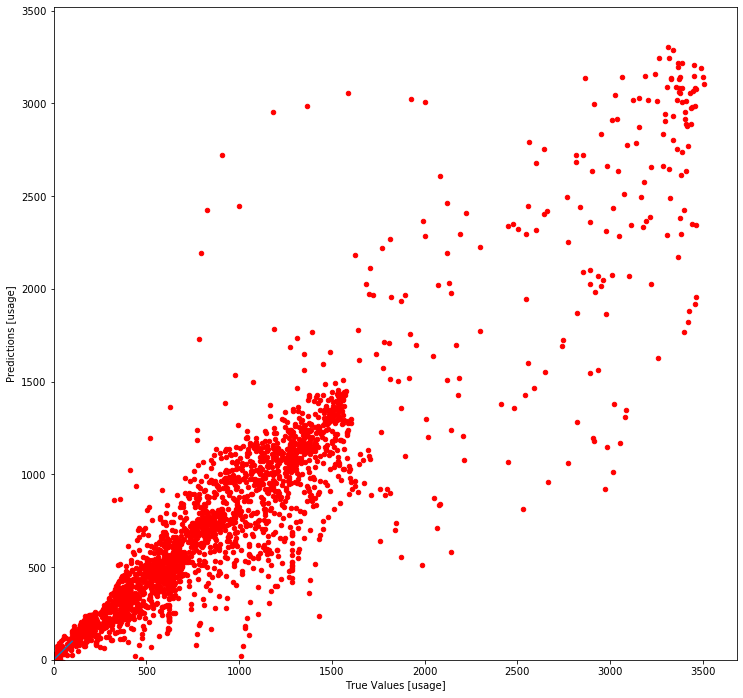

In [84]:
test_predictions_ = model.predict(df_test)
test_predictions = test_predictions_.flatten()
dataset1 = pd.DataFrame({'actual usage': df_test_labels.to_numpy(),
                         'predicted usage': test_predictions})
# print(dataset1);
plt.figure(figsize=(16,12))
plt.scatter(df_test_labels, test_predictions,s=20,c='red')
plt.xlabel('True Values [usage]')
plt.ylabel('Predictions [usage]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
# plt.savefig('output/Prediction-Test_Compare.png')
# dataset1.to_excel("output/actual_predicted.xlsx", index=False)

In [85]:
dataset1["actual usage"].corr(dataset1["predicted usage"])

0.9097994340875947

In [86]:
final_df=df_test_.copy()
final_df["predicted_usage"]=dataset1["predicted usage"].values

In [87]:
final_df.loc[final_df.municipality_id==1]

,timestamp,municipality_id,usage,total_capacity,year,month,day,week_day_name,hour,minute,second,predicted_usage
10390,2017-08-05 08:02:03,1,141,397,2017,8,5,Saturday,8,2,3,139.677155
10400,2017-08-05 08:29:08,1,158,397,2017,8,5,Saturday,8,29,8,177.201721
10410,2017-08-05 09:02:08,1,182,397,2017,8,5,Saturday,9,2,8,211.217224
10421,2017-08-05 09:29:08,1,216,397,2017,8,5,Saturday,9,29,8,229.794891
10435,2017-08-05 10:03:04,1,258,397,2017,8,5,Saturday,10,3,4,261.812469
...,...,...,...,...,...,...,...,...,...,...,...,...
12840,2017-08-18 14:30:27,1,411,397,2017,8,18,Friday,14,30,27,408.965210
12859,2017-08-18 14:56:25,1,411,397,2017,8,18,Friday,14,56,25,418.351196
12866,2017-08-18 15:30:24,1,411,397,2017,8,18,Friday,15,30,24,414.532959
12870,2017-08-18 16:03:27,1,397,397,2017,8,18,Friday,16,3,27,387.659180
